# Idea

Research applicability of Random Forest (RF) and Gradient Boosting Trees (GBT) reaslised in Keras-TensorFlow package.

TODO:
- [ ] Shall add Cut Offs
- [ ] Shall One model version based on CV

# Import Utils

In [1]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin
from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil
import itertools

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Data

In [3]:
features = pd.read_pickle('/kaggle/input/invitro-train-feature-engineer/features.pickle')
test = pd.read_pickle('/kaggle/input/invitro-train-feature-engineer/test_processed.pickle')
train = pd.read_pickle('/kaggle/input/invitro-train-feature-engineer/train_processed.pickle')

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [4]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class", predict_func = np.mean):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        self.predict_func = predict_func
        self.cut_off_lower: float = 0.5
        self.cut_off_upper: float = 0.5
        self.cut_off: float = 0.5
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.X_summary.loc[valid_ids, i] = model.predict(x=valid_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def set_cut_offs(self, lower: float, upper: float):
        
        self.cut_off_lower: float = lower
        self.cut_off_upper: float = upper

    
    def predict_proba(self, X: pd.DataFrame, use_cut_offs: bool = True) -> pd.Series:
        n_splits = len(self.models)
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X[self.features]) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        y_probas = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            y_probas[i] = model.predict(x=X_tf).flatten() 
        
        y_proba: pd.Series = self.predict_func(y_probas, axis=1)
            
        y_proba.name = 'y_hat'
        
        # If cut-offs accepted
        if use_cut_offs:
            # lower
            y_proba = np.where(y_proba < self.cut_off_lower, 0, y_proba)
            # upper
            y_proba = np.where(y_proba > self.cut_off_upper, 1, y_proba)
        
        return y_proba
    
    def predict(self, X: pd.DataFrame) -> pd.Series:
        
        # Simple preidctins
        y_pred = self.predict_proba(X, use_cut_offs=False)
        
        # Round by Threshold
        y_pred = np.where(y_pred < self.cut_off,0,1)
        
        return y_pred
    
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            model.save(filepath=f'{save_path}/models/{fold}')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = tf.keras.models.load_model(f'{save_path}/models/{i}',
                                              custom_objects={"BalancedLogLoss": BalancedLogLoss})
            
        return self

# RandomForestModel

```python
# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')


# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1_load.X_summary
valid_summary_rf_1 = CV_Ensemble_1_load.valid_summary
test_summary_rf_1 = CV_Ensemble_1_load.predict(X=test_out)
model_rf_1 = CV_Ensemble_1_load.models
metrics_rf_1 = CV_Ensemble_1_load.metrics
```

```python
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp
```

##### Fold 1
Use /tmp/tmpur979czw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.090633. Found 514 examples.
Training model...
Model trained in 0:00:00.749800
Compiling model...


[INFO 23-08-01 12:54:33.4080 UTC kernel.cc:1242] Loading model from path /tmp/tmpur979czw/model/ with prefix 5d9d9060f6764643
[INFO 23-08-01 12:54:33.5448 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33286 node(s), and 113 input feature(s).
[INFO 23-08-01 12:54:33.5450 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:54:33.5452 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 380ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3276


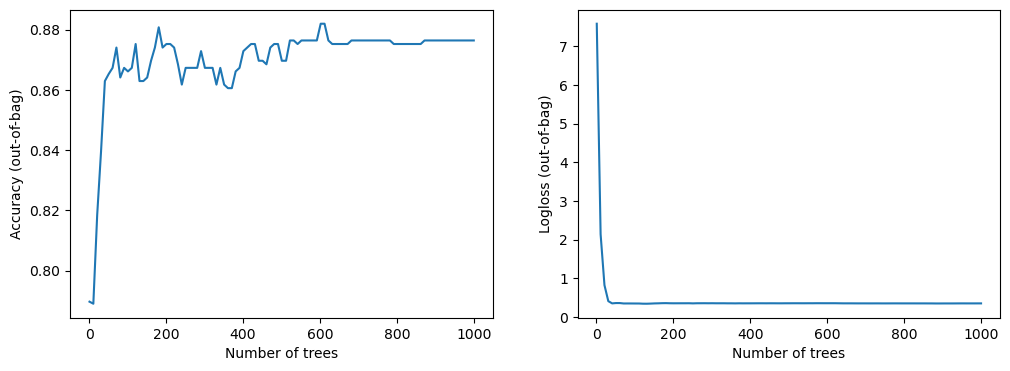


Train: 0.1731 Validation: 0.3276
##### Fold 2
Use /tmp/tmpkfh7r4ax as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.066114. Found 514 examples.
Training model...
Model trained in 0:00:00.706250
Compiling model...


[INFO 23-08-01 12:54:43.3752 UTC kernel.cc:1242] Loading model from path /tmp/tmpkfh7r4ax/model/ with prefix bde0cdebf61a49fe
[INFO 23-08-01 12:54:43.5061 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33396 node(s), and 113 input feature(s).
[INFO 23-08-01 12:54:43.5064 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 377ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9515 - balanced_log_loss: 0.2998


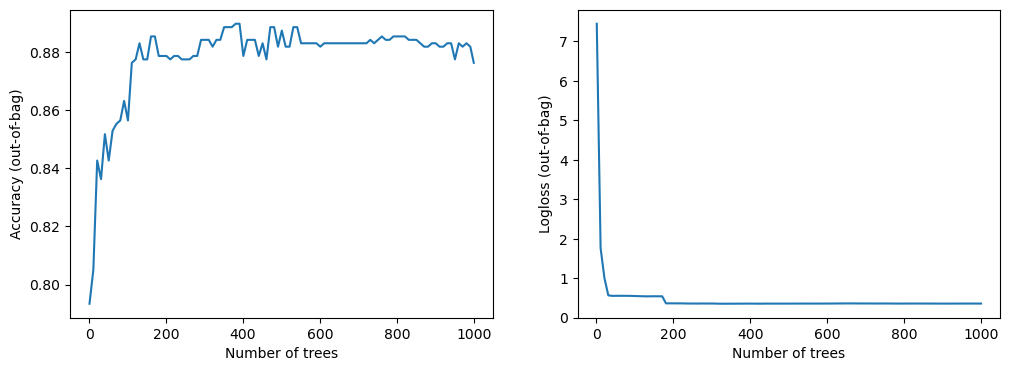


Train: 0.5067 Validation: 0.2998
##### Fold 3
Use /tmp/tmpx0r6j6yv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.021661. Found 514 examples.
Training model...
Model trained in 0:00:00.704965
Compiling model...


[INFO 23-08-01 12:54:50.0518 UTC kernel.cc:1242] Loading model from path /tmp/tmpx0r6j6yv/model/ with prefix 2e6087bae1e34bdf
[INFO 23-08-01 12:54:50.1869 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33376 node(s), and 113 input feature(s).
[INFO 23-08-01 12:54:50.1872 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:54:50.1876 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3269


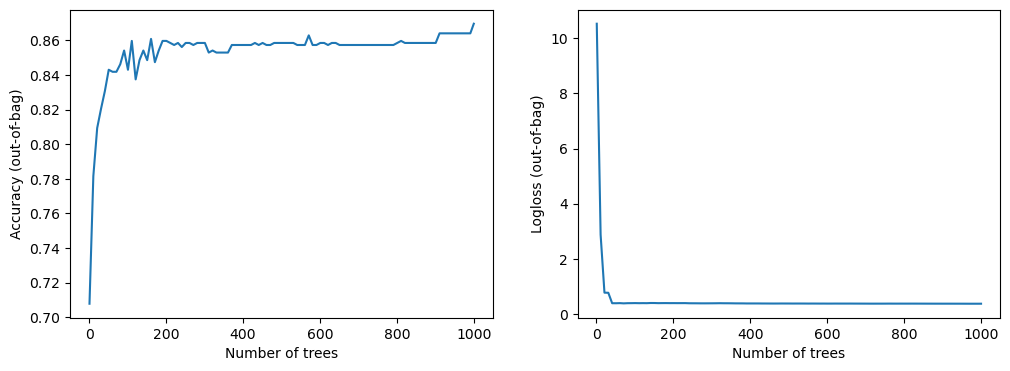


Train: 0.4829 Validation: 0.3269
##### Fold 4
Use /tmp/tmp4jt5ndhd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.427386. Found 514 examples.
Training model...
Model trained in 0:00:00.714358
Compiling model...


[INFO 23-08-01 12:54:57.1911 UTC kernel.cc:1242] Loading model from path /tmp/tmp4jt5ndhd/model/ with prefix 73aa787b0e924f4c
[INFO 23-08-01 12:54:57.3261 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33208 node(s), and 113 input feature(s).
[INFO 23-08-01 12:54:57.3264 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 384ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3500


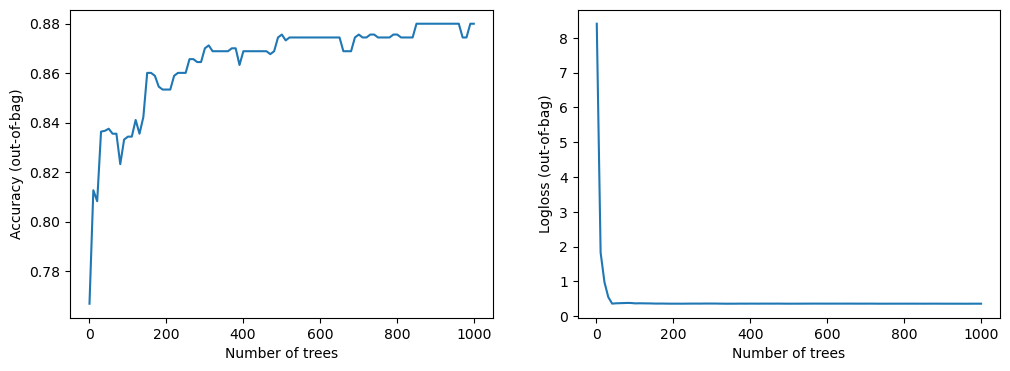


Train: 0.5023 Validation: 0.3500
##### Fold 5
Use /tmp/tmprp5byt61 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.085729. Found 514 examples.
Training model...
Model trained in 0:00:00.706907
Compiling model...


[INFO 23-08-01 12:55:04.0151 UTC kernel.cc:1242] Loading model from path /tmp/tmprp5byt61/model/ with prefix faafe4b6787844f2
[INFO 23-08-01 12:55:04.1483 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33428 node(s), and 113 input feature(s).
[INFO 23-08-01 12:55:04.1484 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:55:04.1485 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 394ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3811


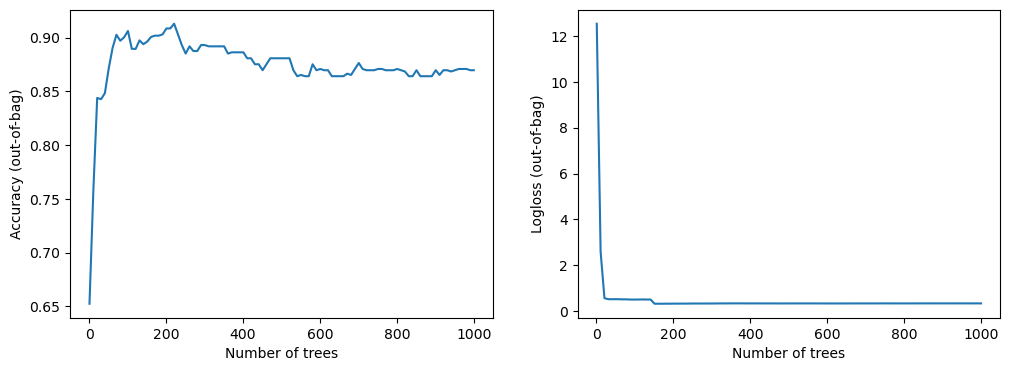


Train: 0.5224 Validation: 0.3811
##### Fold 6
Use /tmp/tmpfodwf3bx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.221129. Found 515 examples.
Training model...
Model trained in 0:00:00.730105
Compiling model...


[INFO 23-08-01 12:55:10.9354 UTC kernel.cc:1242] Loading model from path /tmp/tmpfodwf3bx/model/ with prefix 1c7d72eaec364020
[INFO 23-08-01 12:55:11.0739 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33260 node(s), and 114 input feature(s).
[INFO 23-08-01 12:55:11.0740 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 387ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9020 - balanced_log_loss: 0.4208


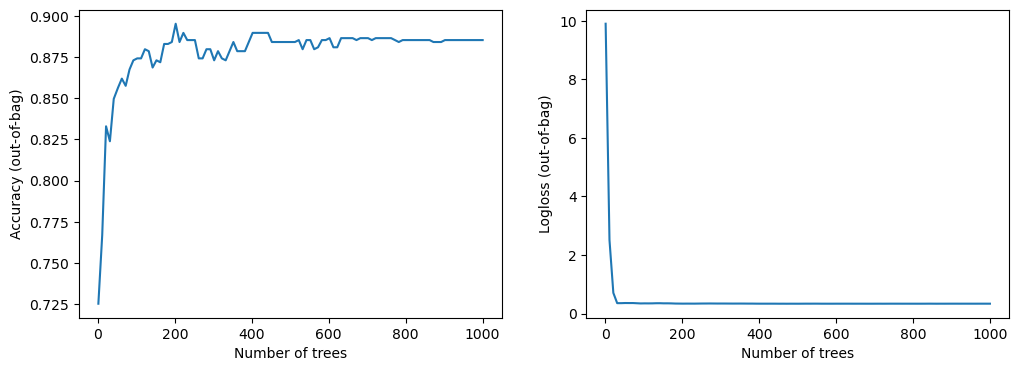


Train: 0.5493 Validation: 0.4208

Train mean: 0.4561 std: 0.1404

Validation mean: 0.3510 std: 0.0437


In [5]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_1 = CV_Ensemble_RF_1.fit(X=train, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_RF_1.save(save_path='/kaggle/working/RF/1')

# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

# train_summary_rf_1 = CV_Ensemble_1.X_summary
# valid_summary_rf_1 = CV_Ensemble_1.valid_summary
# test_summary_rf_1 = CV_Ensemble_1.predict_proba(X=test_out, use_cut_offs=False)
# model_rf_1 = CV_Ensemble_1.models
# metrics_rf_1 = CV_Ensemble_1.metrics

##### Fold 1
Use /tmp/tmpxbjc5q3j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.898985. Found 555 examples.
Training model...
Model trained in 0:00:00.246675
Compiling model...


[INFO 23-08-01 12:55:52.0335 UTC kernel.cc:1242] Loading model from path /tmp/tmpxbjc5q3j/model/ with prefix 675bf4b87a384c1b
[INFO 23-08-01 12:55:52.0772 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10268 node(s), and 112 input feature(s).
[INFO 23-08-01 12:55:52.0774 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:55:52.0774 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 375ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3026


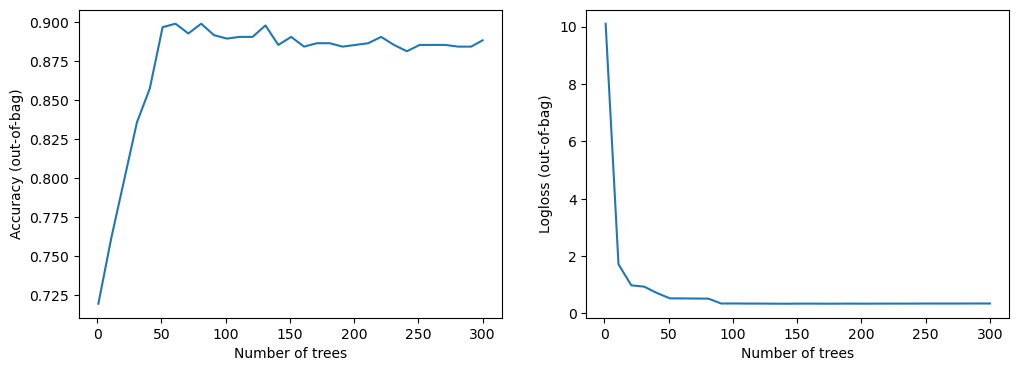


Train: 0.1776 Validation: 0.3026
##### Fold 2
Use /tmp/tmpm8gzq0or as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.062879. Found 555 examples.
Training model...
Model trained in 0:00:00.238814
Compiling model...


[INFO 23-08-01 12:55:58.2282 UTC kernel.cc:1242] Loading model from path /tmp/tmpm8gzq0or/model/ with prefix df1be05c8b464b25
[INFO 23-08-01 12:55:58.2700 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10250 node(s), and 110 input feature(s).
[INFO 23-08-01 12:55:58.2700 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 397ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3518


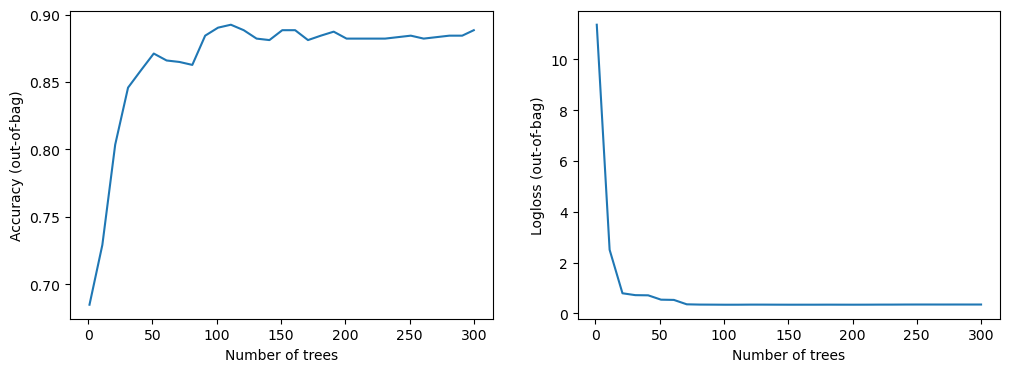


Train: 0.4775 Validation: 0.3518
##### Fold 3
Use /tmp/tmprr484_41 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.245275. Found 555 examples.
Training model...
Model trained in 0:00:00.264389
Compiling model...


[INFO 23-08-01 12:56:04.5906 UTC kernel.cc:1242] Loading model from path /tmp/tmprr484_41/model/ with prefix 2062bf77a5aa44ff
[INFO 23-08-01 12:56:04.6353 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10302 node(s), and 113 input feature(s).
[INFO 23-08-01 12:56:04.6353 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:56:04.6354 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 387ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2532


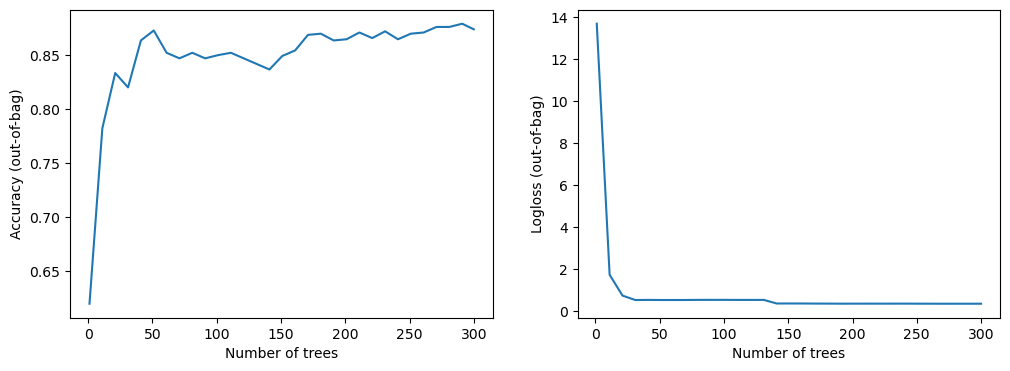


Train: 0.5394 Validation: 0.2532
##### Fold 4
Use /tmp/tmppkocriga as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.244728. Found 555 examples.
Training model...
Model trained in 0:00:00.321670
Compiling model...


[INFO 23-08-01 12:56:12.1882 UTC kernel.cc:1242] Loading model from path /tmp/tmppkocriga/model/ with prefix a3079a7428bf4412
[INFO 23-08-01 12:56:12.2342 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10350 node(s), and 112 input feature(s).
[INFO 23-08-01 12:56:12.2344 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3232


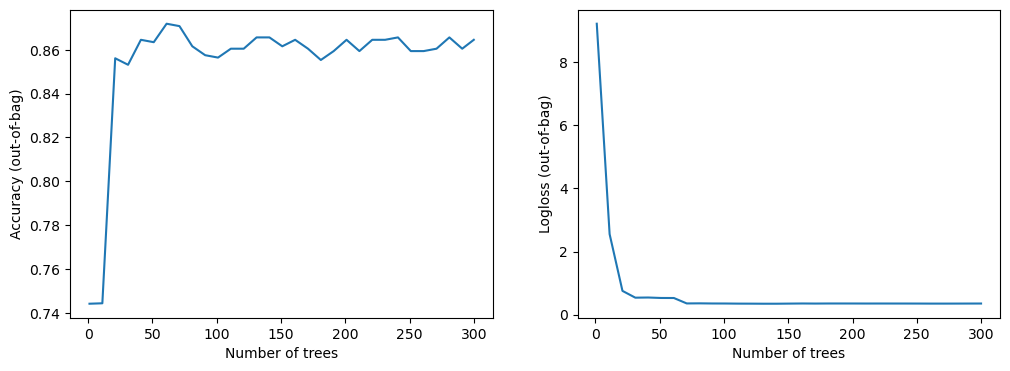


Train: 0.4308 Validation: 0.3232
##### Fold 5
Use /tmp/tmpovm7oewe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.198478. Found 555 examples.
Training model...
Model trained in 0:00:00.249564
Compiling model...


[INFO 23-08-01 12:56:18.6432 UTC kernel.cc:1242] Loading model from path /tmp/tmpovm7oewe/model/ with prefix ca4ee946b9404863
[INFO 23-08-01 12:56:18.6849 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10290 node(s), and 112 input feature(s).
[INFO 23-08-01 12:56:18.6849 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:56:18.6849 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3334


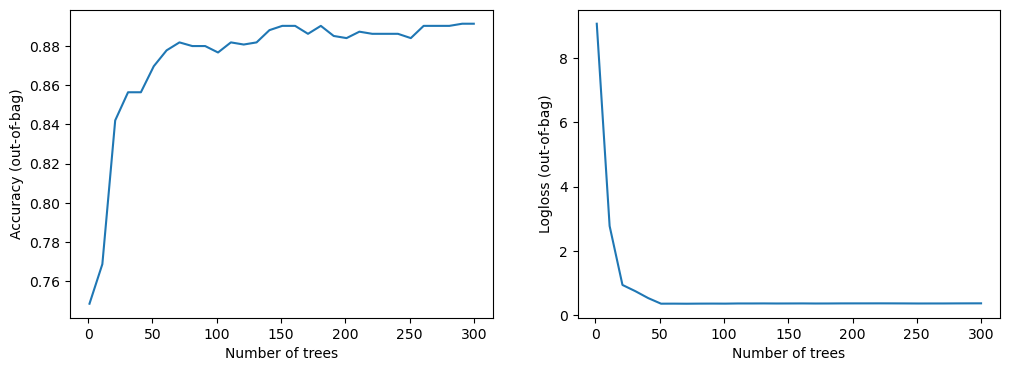


Train: 0.5062 Validation: 0.3334
##### Fold 6
Use /tmp/tmp6zqwue24 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.606799. Found 555 examples.
Training model...
Model trained in 0:00:00.242705
Compiling model...


[INFO 23-08-01 12:56:26.4722 UTC kernel.cc:1242] Loading model from path /tmp/tmp6zqwue24/model/ with prefix fca0a751303144d9
[INFO 23-08-01 12:56:26.5141 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10464 node(s), and 113 input feature(s).
[INFO 23-08-01 12:56:26.5142 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4007


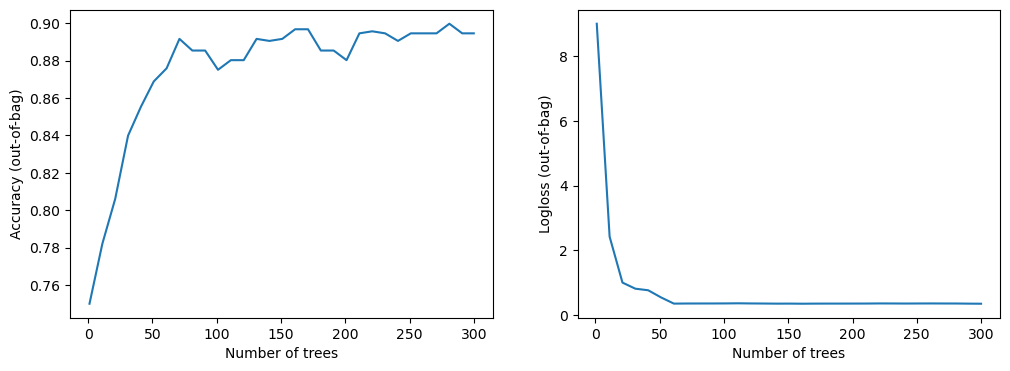


Train: 0.5031 Validation: 0.4007
##### Fold 7
Use /tmp/tmpzd2um5p9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.101037. Found 555 examples.
Training model...
Model trained in 0:00:00.238999
Compiling model...


[INFO 23-08-01 12:56:32.6904 UTC kernel.cc:1242] Loading model from path /tmp/tmpzd2um5p9/model/ with prefix 093bc1543aa84ff7
[INFO 23-08-01 12:56:32.7324 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10096 node(s), and 113 input feature(s).
[INFO 23-08-01 12:56:32.7324 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:56:32.7325 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 376ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3264


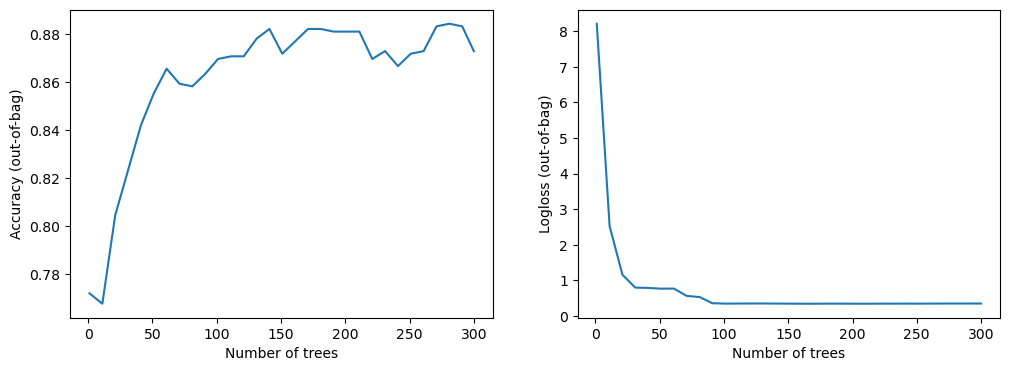


Train: 0.5776 Validation: 0.3264
##### Fold 8
Use /tmp/tmp59fvapmf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.082132. Found 556 examples.
Training model...
Model trained in 0:00:00.239737
Compiling model...


[INFO 23-08-01 12:56:39.9778 UTC kernel.cc:1242] Loading model from path /tmp/tmp59fvapmf/model/ with prefix 422a0dfe48ba4c86
[INFO 23-08-01 12:56:40.0190 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10276 node(s), and 113 input feature(s).
[INFO 23-08-01 12:56:40.0191 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.3201


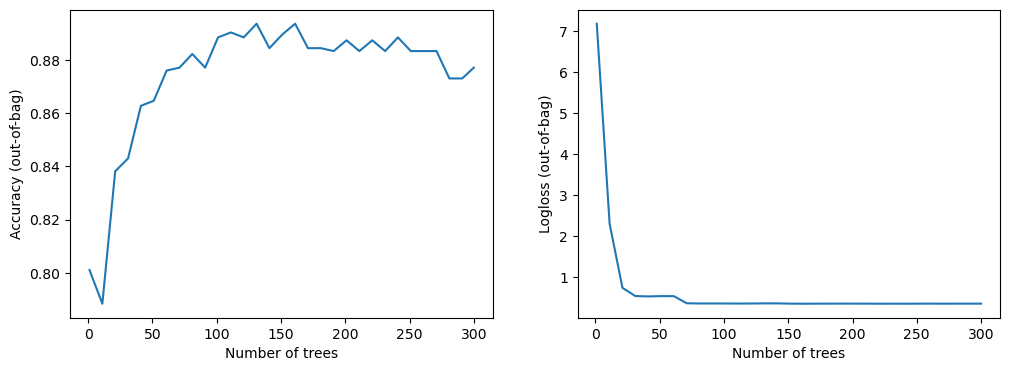


Train: 0.5045 Validation: 0.3201
##### Fold 9
Use /tmp/tmp31dtset3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.111009. Found 556 examples.
Training model...
Model trained in 0:00:00.237741
Compiling model...


[INFO 23-08-01 12:56:47.3357 UTC kernel.cc:1242] Loading model from path /tmp/tmp31dtset3/model/ with prefix d003428ea7354cd5
[INFO 23-08-01 12:56:47.3765 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10168 node(s), and 112 input feature(s).
[INFO 23-08-01 12:56:47.3765 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:56:47.3766 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 407ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4664


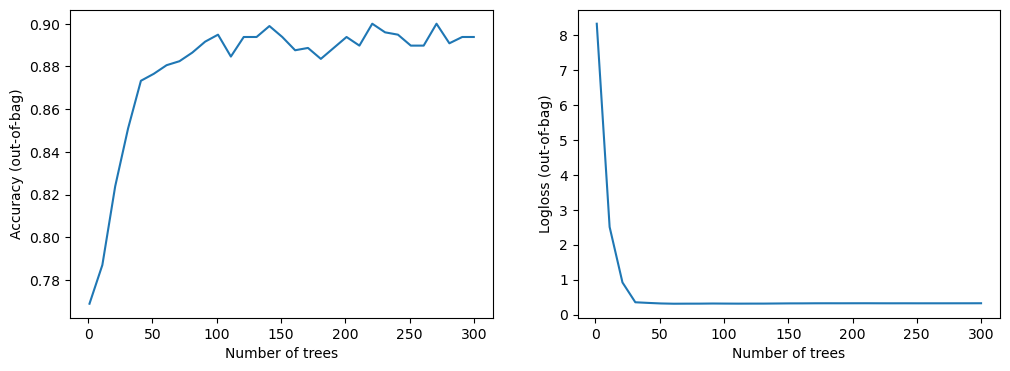


Train: 0.4883 Validation: 0.4664
##### Fold 10
Use /tmp/tmptqqac2fh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.119029. Found 556 examples.
Training model...
Model trained in 0:00:00.241404
Compiling model...


[INFO 23-08-01 12:56:54.7072 UTC kernel.cc:1242] Loading model from path /tmp/tmptqqac2fh/model/ with prefix 30ef8444afab49a3
[INFO 23-08-01 12:56:54.7495 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10406 node(s), and 111 input feature(s).
[INFO 23-08-01 12:56:54.7495 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 375ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.3531


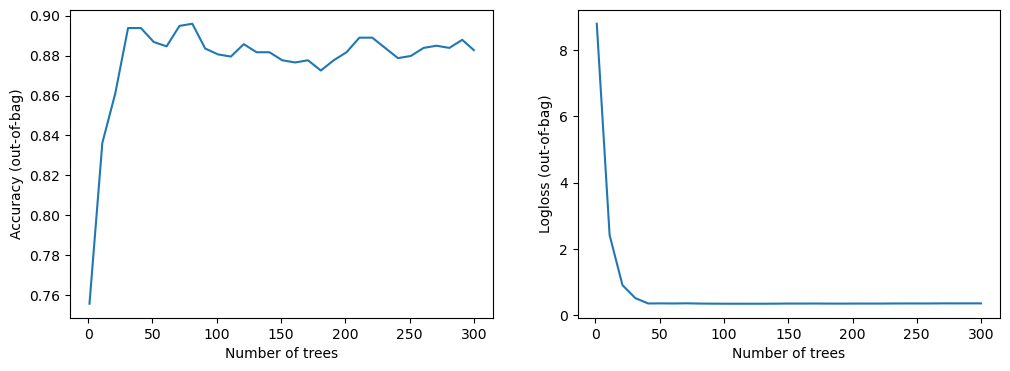


Train: 0.6396 Validation: 0.3531

Train mean: 0.4845 std: 0.1221

Validation mean: 0.3431 std: 0.0574


In [6]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_2 = CV_Ensemble_RF_2.fit(X=train, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_RF_2.save(save_path='/kaggle/working/RF/2')

# Collect attributes and predictions

# train_summary_rf_2 = CV_Ensemble_2.X_summary
# valid_summary_rf_2 = CV_Ensemble_2.valid_summary
# test_summary_rf_2 = CV_Ensemble_2.predict(X=test_out)
# model_rf_2 = CV_Ensemble_2.models
# metrics_rf_2 = CV_Ensemble_2.metrics


##### Fold 1
Use /tmp/tmpz5ezx6dl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.233337. Found 555 examples.
Training model...
Model trained in 0:00:00.186888
Compiling model...


[INFO 23-08-01 12:57:56.8976 UTC kernel.cc:1242] Loading model from path /tmp/tmpz5ezx6dl/model/ with prefix 30e60f083cc24975
[INFO 23-08-01 12:57:56.9419 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11260 node(s), and 59 input feature(s).
[INFO 23-08-01 12:57:56.9419 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:57:56.9420 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3091


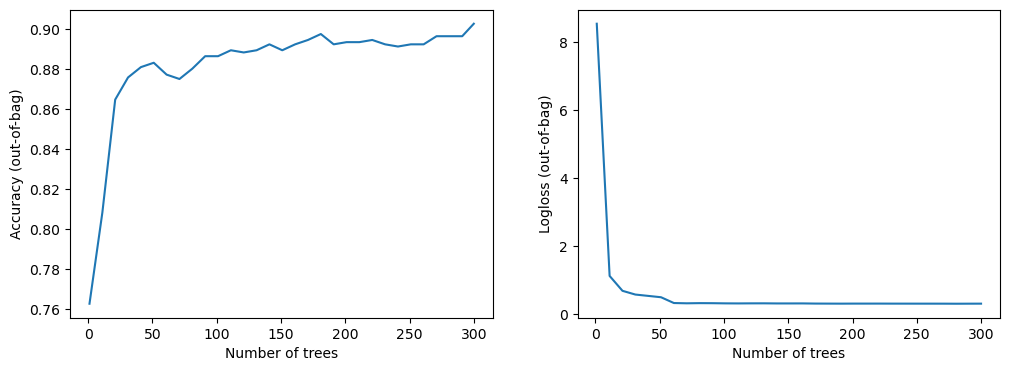


Train: 0.1883 Validation: 0.3091
##### Fold 2
Use /tmp/tmpz359wi8r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.219490. Found 555 examples.
Training model...
Model trained in 0:00:00.185082
Compiling model...


[INFO 23-08-01 12:58:00.8828 UTC kernel.cc:1242] Loading model from path /tmp/tmpz359wi8r/model/ with prefix 91a0777ab0e44390
[INFO 23-08-01 12:58:00.9269 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:00.9269 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3418


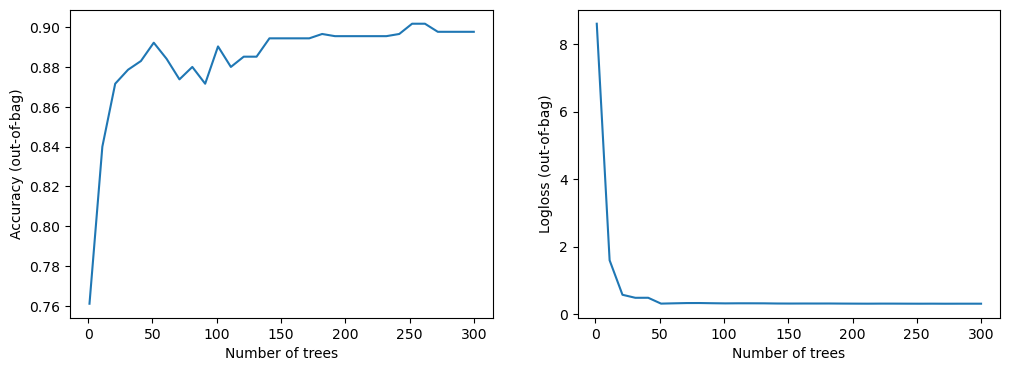


Train: 0.4968 Validation: 0.3418
##### Fold 3
Use /tmp/tmpkzc_8dyj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.198857. Found 555 examples.
Training model...
Model trained in 0:00:00.186247
Compiling model...


[INFO 23-08-01 12:58:04.8597 UTC kernel.cc:1242] Loading model from path /tmp/tmpkzc_8dyj/model/ with prefix 175a67b7b7d649fb
[INFO 23-08-01 12:58:04.9041 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:04.9042 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2186


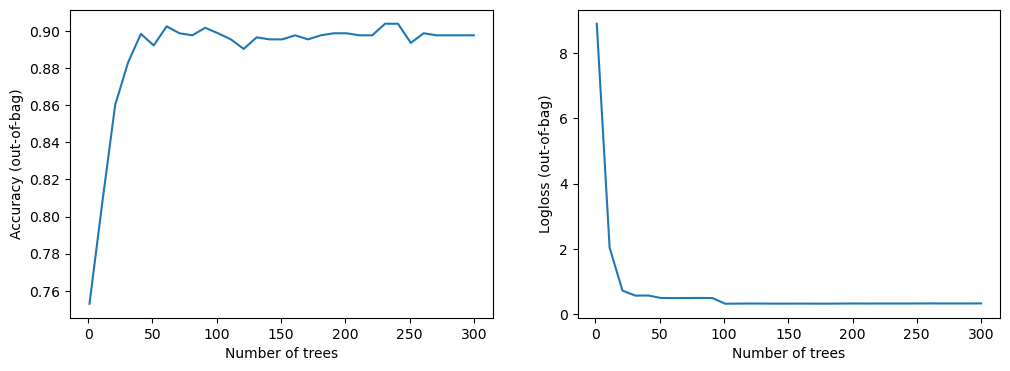


Train: 0.5382 Validation: 0.2186
##### Fold 4
Use /tmp/tmpro0ool03 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.210009. Found 555 examples.
Training model...
Model trained in 0:00:00.187007
Compiling model...


[INFO 23-08-01 12:58:08.7797 UTC kernel.cc:1242] Loading model from path /tmp/tmpro0ool03/model/ with prefix dcfbc50df019466b
[INFO 23-08-01 12:58:08.8242 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11274 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:08.8242 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:58:08.8243 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2880


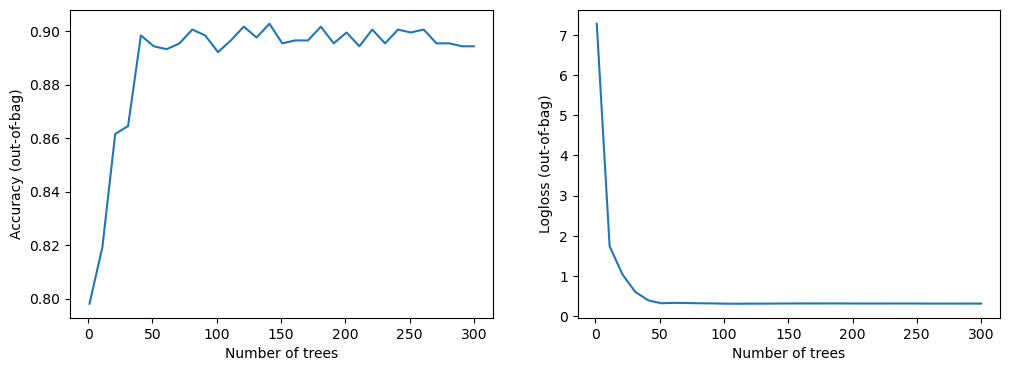


Train: 0.4091 Validation: 0.2880
##### Fold 5
Use /tmp/tmprkp9wuv3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.217531. Found 555 examples.
Training model...
Model trained in 0:00:00.190491
Compiling model...


[INFO 23-08-01 12:58:13.1533 UTC kernel.cc:1242] Loading model from path /tmp/tmprkp9wuv3/model/ with prefix 542050f7bca64b74
[INFO 23-08-01 12:58:13.1982 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11210 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:13.1983 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2901


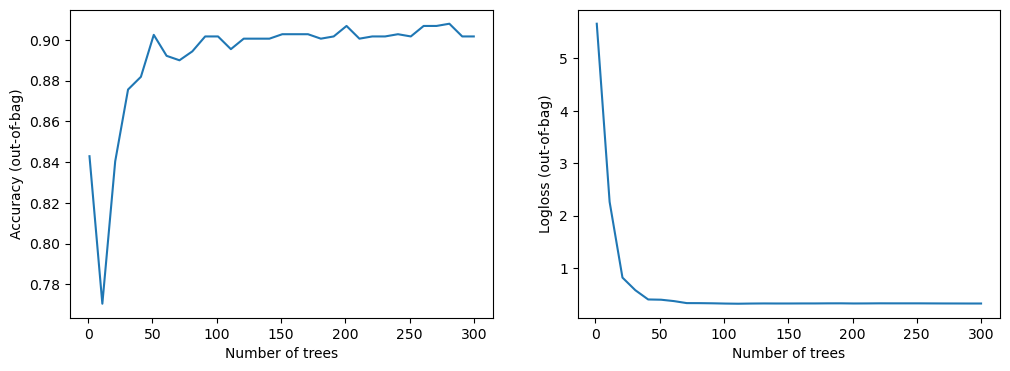


Train: 0.4847 Validation: 0.2901
##### Fold 6
Use /tmp/tmp3c_kkglb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.236180. Found 555 examples.
Training model...
Model trained in 0:00:00.234950
Compiling model...


[INFO 23-08-01 12:58:17.1671 UTC kernel.cc:1242] Loading model from path /tmp/tmp3c_kkglb/model/ with prefix 84a2f71ec1ea4ace
[INFO 23-08-01 12:58:17.2164 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11268 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:17.2165 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 304ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3444


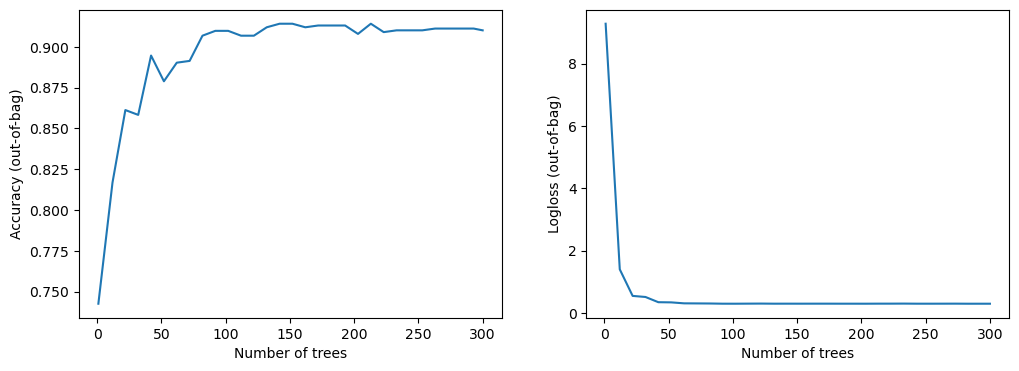


Train: 0.4697 Validation: 0.3444
##### Fold 7
Use /tmp/tmpwqb_5bh0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.325494. Found 555 examples.
Training model...
Model trained in 0:00:00.191084
Compiling model...


[INFO 23-08-01 12:58:22.2527 UTC kernel.cc:1242] Loading model from path /tmp/tmpwqb_5bh0/model/ with prefix 30008fccdede4303
[INFO 23-08-01 12:58:22.3004 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11172 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:22.3005 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:58:22.3005 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2836


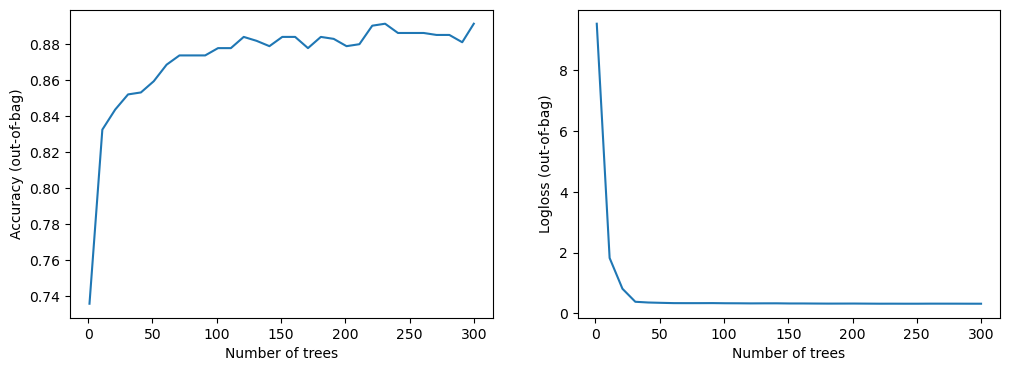


Train: 0.5343 Validation: 0.2836
##### Fold 8
Use /tmp/tmpr6t_98d7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.217501. Found 556 examples.
Training model...
Model trained in 0:00:00.201018
Compiling model...


[INFO 23-08-01 12:58:26.2260 UTC kernel.cc:1242] Loading model from path /tmp/tmpr6t_98d7/model/ with prefix fe0b9d578c1349d8
[INFO 23-08-01 12:58:26.2698 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11026 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:26.2699 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2572


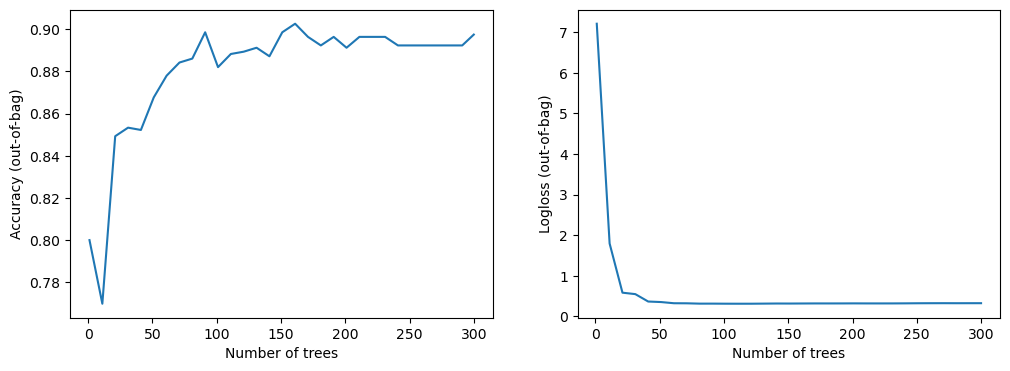


Train: 0.4778 Validation: 0.2572
##### Fold 9
Use /tmp/tmp84uru5ae as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.169919. Found 556 examples.
Training model...
Model trained in 0:00:00.184994
Compiling model...


[INFO 23-08-01 12:58:30.1063 UTC kernel.cc:1242] Loading model from path /tmp/tmp84uru5ae/model/ with prefix eb3ec1809fcc4d6d
[INFO 23-08-01 12:58:30.1510 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11098 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:30.1511 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4250


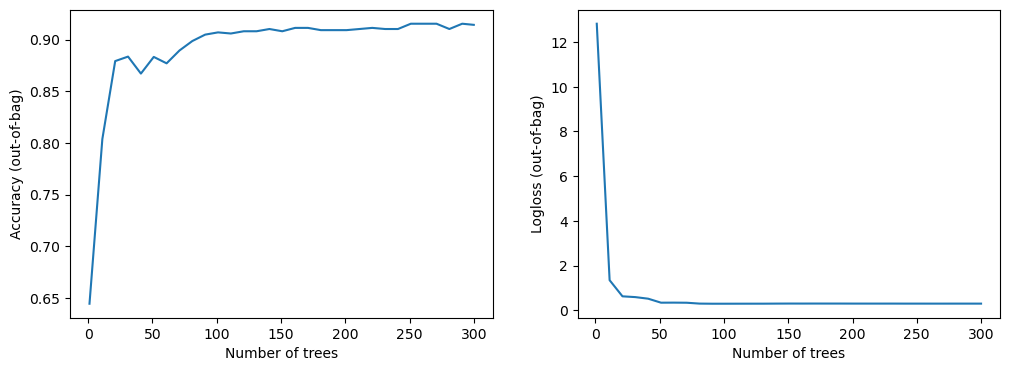


Train: 0.4395 Validation: 0.4250
##### Fold 10
Use /tmp/tmpsw0nos9c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.173173. Found 556 examples.
Training model...
Model trained in 0:00:00.183380
Compiling model...


[INFO 23-08-01 12:58:34.0115 UTC kernel.cc:1242] Loading model from path /tmp/tmpsw0nos9c/model/ with prefix 7e1c5ff7b3754a58
[INFO 23-08-01 12:58:34.0568 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11344 node(s), and 58 input feature(s).
[INFO 23-08-01 12:58:34.0569 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:58:34.0569 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3016


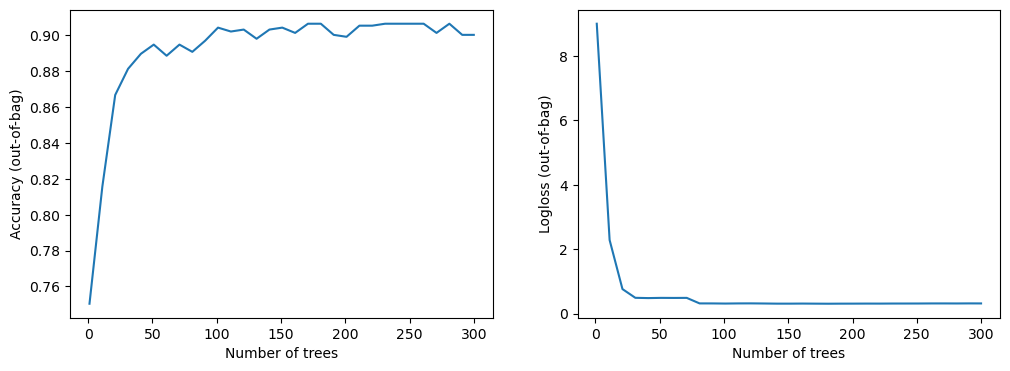


Train: 0.6154 Validation: 0.3016

Train mean: 0.4654 std: 0.1129

Validation mean: 0.3059 std: 0.0558


In [7]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_3 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_3 = CV_Ensemble_RF_3.fit(X=train, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_RF_3.save(save_path='/kaggle/working/RF/3')

# Collect attributes and predictions

# train_summary_rf_3 = CV_Ensemble_3.X_summary
# valid_summary_rf_3 = CV_Ensemble_3.valid_summary
# test_summary_rf_3 = CV_Ensemble_3.predict(X=test_out)
# model_rf_3 = CV_Ensemble_3.models
# metrics_rf_3 = CV_Ensemble_3.metrics

##### Fold 1
Use /tmp/tmp2qle30o5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.228634. Found 308 examples.
Training model...


[INFO 23-08-01 12:59:13.1377 UTC kernel.cc:1242] Loading model from path /tmp/tmp2qle30o5/model/ with prefix 8f4a7a01b3724bcd


Model trained in 0:00:02.307983
Compiling model...


[INFO 23-08-01 12:59:13.7159 UTC decision_forest.cc:660] Model loaded with 20000 root(s), 139246 node(s), and 58 input feature(s).
[INFO 23-08-01 12:59:13.7159 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-01 12:59:13.7160 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 309ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9191 - balanced_log_loss: 0.3833


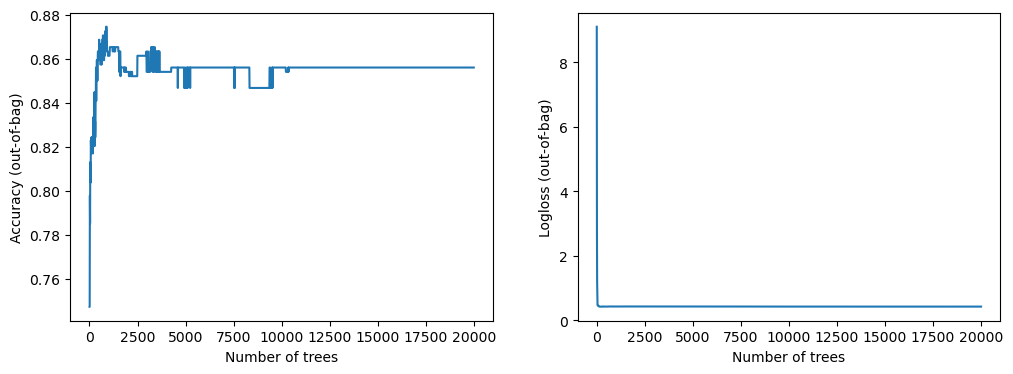


Train: 0.3452 Validation: 0.3833
##### Fold 2
Use /tmp/tmp5jm_eosp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.184240. Found 309 examples.
Training model...


[INFO 23-08-01 12:59:20.2321 UTC kernel.cc:1242] Loading model from path /tmp/tmp5jm_eosp/model/ with prefix a9c9fcb748054213


Model trained in 0:00:02.515805
Compiling model...


[INFO 23-08-01 12:59:20.8339 UTC decision_forest.cc:660] Model loaded with 20000 root(s), 139766 node(s), and 59 input feature(s).
[INFO 23-08-01 12:59:20.8339 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 316ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9123 - balanced_log_loss: 0.3998


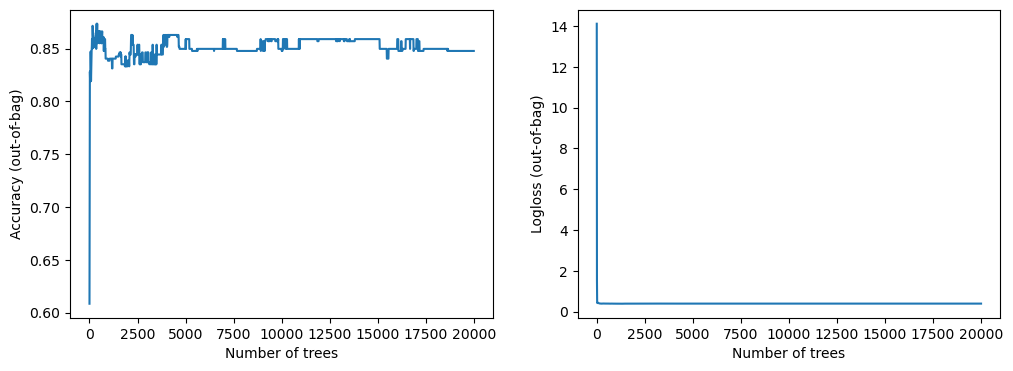


Train: 0.7033 Validation: 0.3998

Train mean: 0.5243 std: 0.2532

Validation mean: 0.3915 std: 0.0116


In [8]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_4 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_4 = CV_Ensemble_RF_4.fit(X=train, 
                                  features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=3, num_trees=20000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))


# save
CV_Ensemble_RF_4.save(save_path='/kaggle/working/RF/4')

# GradientBoostedTreesModel

##### Fold 1
Use /tmp/tmpbdjaoi4e as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:32.2634 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:32.2635 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:32.2635 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.193106. Found 555 examples.
Training model...
Model trained in 0:00:00.739619
Compiling model...


[INFO 23-08-01 12:59:34.2003 UTC kernel.cc:1242] Loading model from path /tmp/tmpbdjaoi4e/model/ with prefix 072a2c5b3c8e4e3e
[INFO 23-08-01 12:59:34.2057 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 12:59:34.2058 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2432


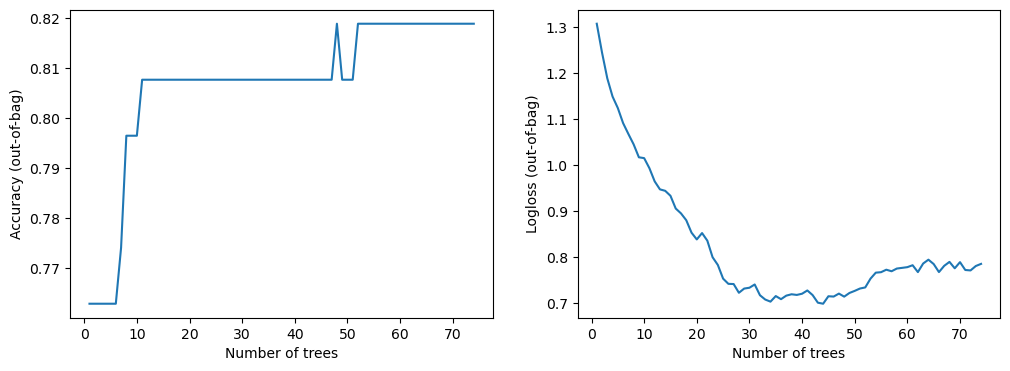


Train: 0.0893 Validation: 0.2432
##### Fold 2
Use /tmp/tmpp5xclyxg as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:37.8992 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:37.8992 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:37.8993 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.194369. Found 555 examples.
Training model...
Model trained in 0:00:00.693519
Compiling model...


[INFO 23-08-01 12:59:39.7918 UTC kernel.cc:1242] Loading model from path /tmp/tmpp5xclyxg/model/ with prefix e631ff5ddd6e40e6
[INFO 23-08-01 12:59:39.7968 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2464


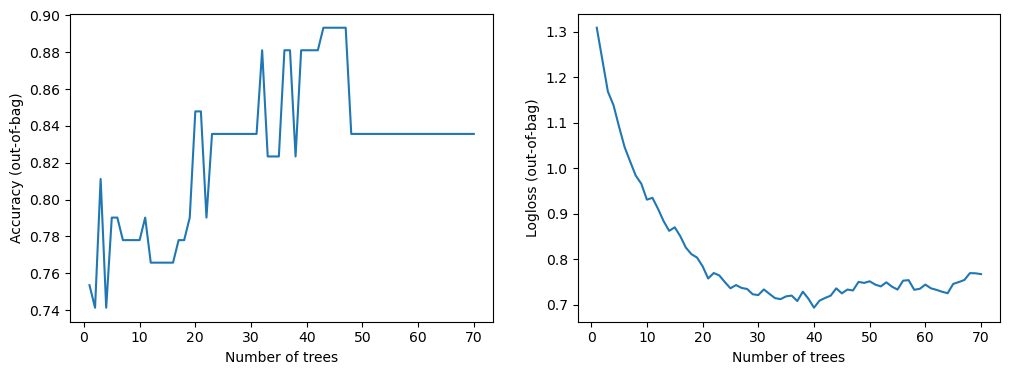


Train: 0.3326 Validation: 0.2464
##### Fold 3
Use /tmp/tmpmjbwbpdo as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:42.3429 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:42.3430 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:42.3430 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.201226. Found 555 examples.
Training model...
Model trained in 0:00:00.854503
Compiling model...


[INFO 23-08-01 12:59:44.4000 UTC kernel.cc:1242] Loading model from path /tmp/tmpmjbwbpdo/model/ with prefix e2dbf69f7d314be5
[INFO 23-08-01 12:59:44.4072 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 12:59:44.4073 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1154


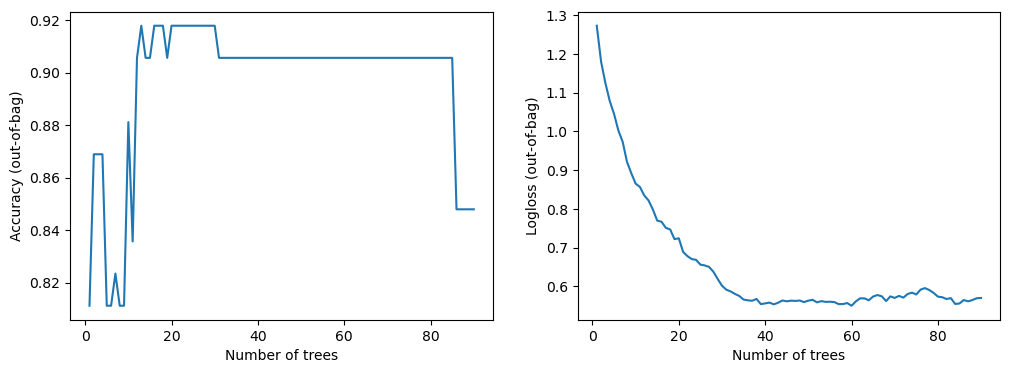


Train: 0.3043 Validation: 0.1154
##### Fold 4
Use /tmp/tmpdv43klzx as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:47.9558 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:47.9558 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:47.9559 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.254978. Found 555 examples.
Training model...
Model trained in 0:00:00.644886
Compiling model...


[INFO 23-08-01 12:59:49.8599 UTC kernel.cc:1242] Loading model from path /tmp/tmpdv43klzx/model/ with prefix 05092fef59834366
[INFO 23-08-01 12:59:49.8646 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2950


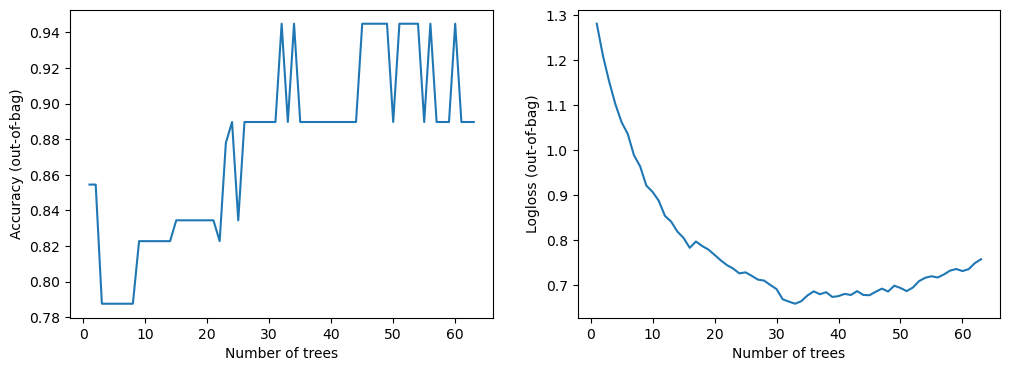


Train: 0.2279 Validation: 0.2950
##### Fold 5
Use /tmp/tmp5zcck017 as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:53.6314 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:53.6315 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:53.6315 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.213278. Found 555 examples.
Training model...
Model trained in 0:00:00.974546
Compiling model...


[INFO 23-08-01 12:59:55.8191 UTC kernel.cc:1242] Loading model from path /tmp/tmp5zcck017/model/ with prefix a471e80108674c14
[INFO 23-08-01 12:59:55.8276 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 12:59:55.8277 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 291ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2456


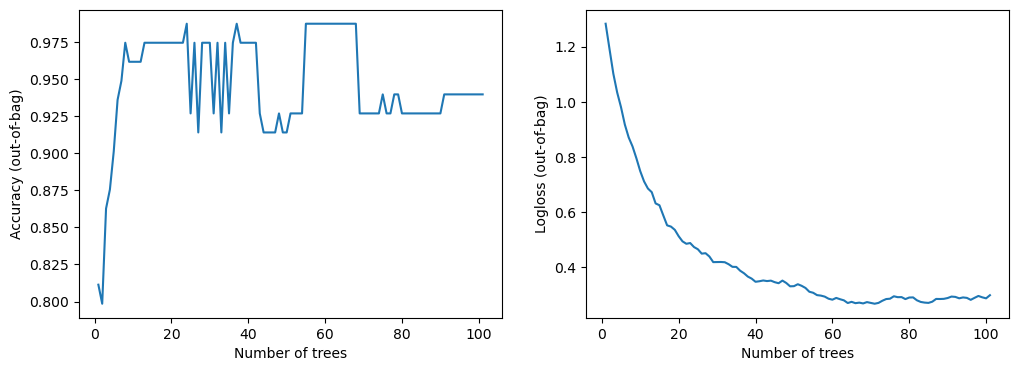


Train: 0.3301 Validation: 0.2456
##### Fold 6
Use /tmp/tmp115w9i2h as temporary training directory
Reading training dataset...


[WARNING 23-08-01 12:59:59.4234 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:59.4234 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 12:59:59.4234 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.303570. Found 555 examples.
Training model...
Model trained in 0:00:00.889088
Compiling model...


[INFO 23-08-01 13:00:01.6177 UTC kernel.cc:1242] Loading model from path /tmp/tmp115w9i2h/model/ with prefix 54d00cfbf6a54fac
[INFO 23-08-01 13:00:01.6251 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3147


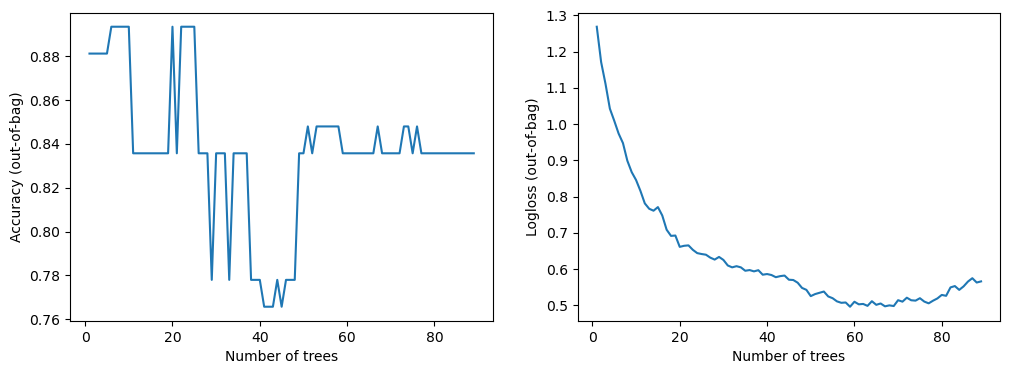


Train: 0.2965 Validation: 0.3147
##### Fold 7
Use /tmp/tmp99ikq1zg as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:00:04.2260 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:04.2260 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:04.2260 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.249438. Found 555 examples.
Training model...
Model trained in 0:00:01.005709
Compiling model...


[INFO 23-08-01 13:00:06.4805 UTC kernel.cc:1242] Loading model from path /tmp/tmp99ikq1zg/model/ with prefix db49b10dd2bf4c9a
[INFO 23-08-01 13:00:06.4897 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:00:06.4897 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3183


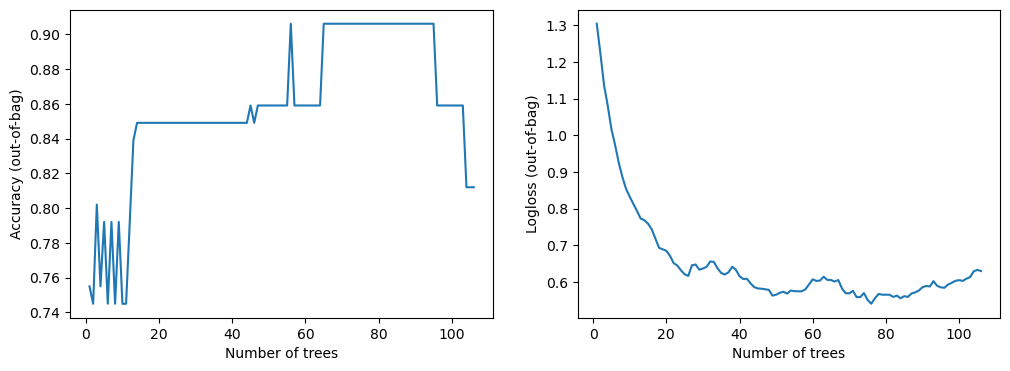


Train: 0.3593 Validation: 0.3183
##### Fold 8
Use /tmp/tmp6diqkuuf as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:00:09.0550 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:09.0550 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:09.0551 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.237273. Found 556 examples.
Training model...
Model trained in 0:00:01.090917
Compiling model...


[INFO 23-08-01 13:00:11.3822 UTC kernel.cc:1242] Loading model from path /tmp/tmp6diqkuuf/model/ with prefix edb7ff81b8314bf9
[INFO 23-08-01 13:00:11.3920 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1722


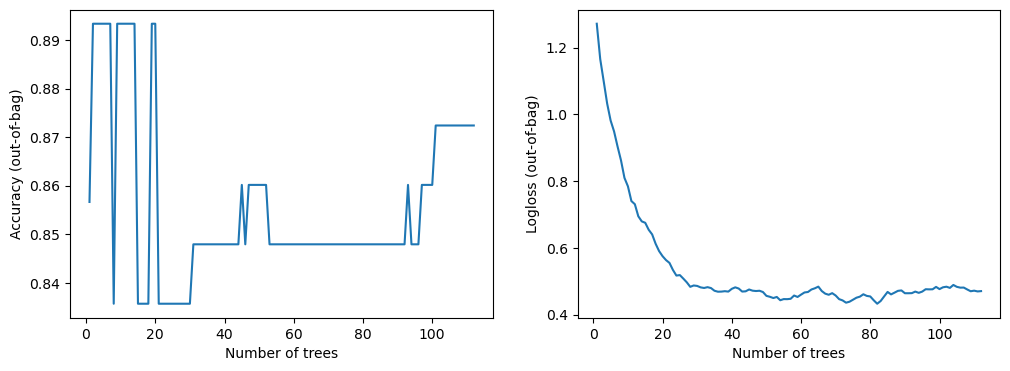


Train: 0.3549 Validation: 0.1722
##### Fold 9
Use /tmp/tmpkfymik6n as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:00:13.9243 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:13.9243 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:13.9243 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.227320. Found 556 examples.
Training model...
Model trained in 0:00:01.942679
Compiling model...


[INFO 23-08-01 13:00:17.0838 UTC kernel.cc:1242] Loading model from path /tmp/tmpkfymik6n/model/ with prefix 6edb0b5f5b234a67
[INFO 23-08-01 13:00:17.1035 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:00:17.1035 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 275ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.9113


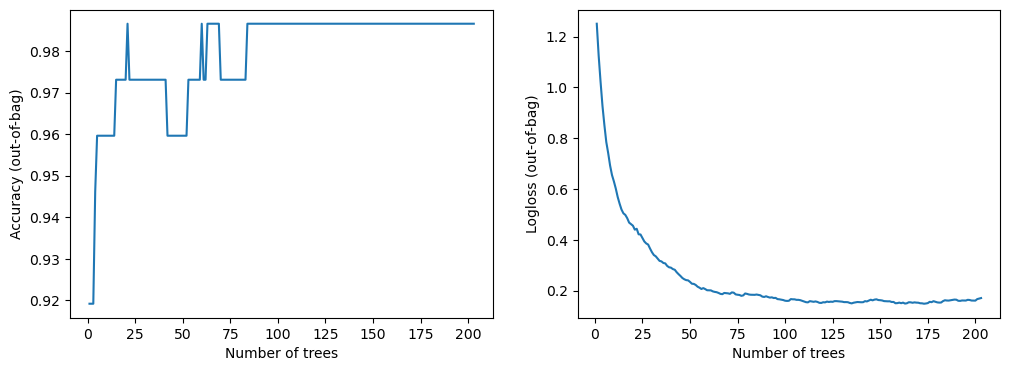


Train: 0.1788 Validation: 0.9113
##### Fold 10
Use /tmp/tmp97nx7zh5 as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:00:19.7510 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:19.7510 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:19.7510 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.283822. Found 556 examples.
Training model...
Model trained in 0:00:01.341624
Compiling model...


[INFO 23-08-01 13:00:22.3711 UTC kernel.cc:1242] Loading model from path /tmp/tmp97nx7zh5/model/ with prefix c466c8a5a122426b
[INFO 23-08-01 13:00:22.3858 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1701


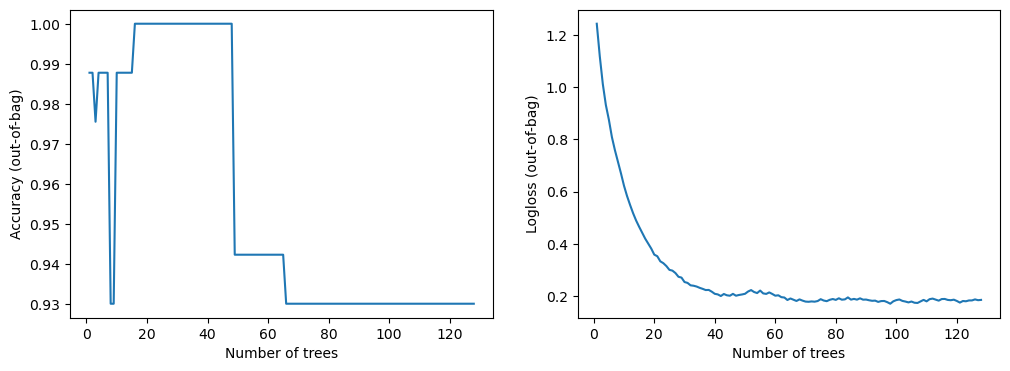


Train: 0.9280 Validation: 0.1701

Train mean: 0.3402 std: 0.2239

Validation mean: 0.3032 std: 0.2237


In [9]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_1 = CV_Ensemble_GBT_1.fit(X=train, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=5, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_1.save(save_path='/kaggle/working/GBT/1')

# Collect attributes and predictions

# train_summary_gbt_1 = CV_Ensemble_GBT_1.X_summary
# valid_summary_gbt_1 = CV_Ensemble_GBT_1.valid_summary
# test_summary_gbt_1 = CV_Ensemble_GBT_1.predict(X=test_out)
# model_gbt_1 = CV_Ensemble_GBT_1.models
# metrics_gbt_1 = CV_Ensemble_GBT_1.metrics

##### Fold 1
Use /tmp/tmphmp2uqq4 as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:00:59.1504 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:59.1504 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:00:59.1504 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.385799. Found 555 examples.
Training model...
Model trained in 0:00:01.269352
Compiling model...


[INFO 23-08-01 13:01:01.8044 UTC kernel.cc:1242] Loading model from path /tmp/tmphmp2uqq4/model/ with prefix bb10f22562bb4add
[INFO 23-08-01 13:01:01.8157 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:01:01.8157 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2472


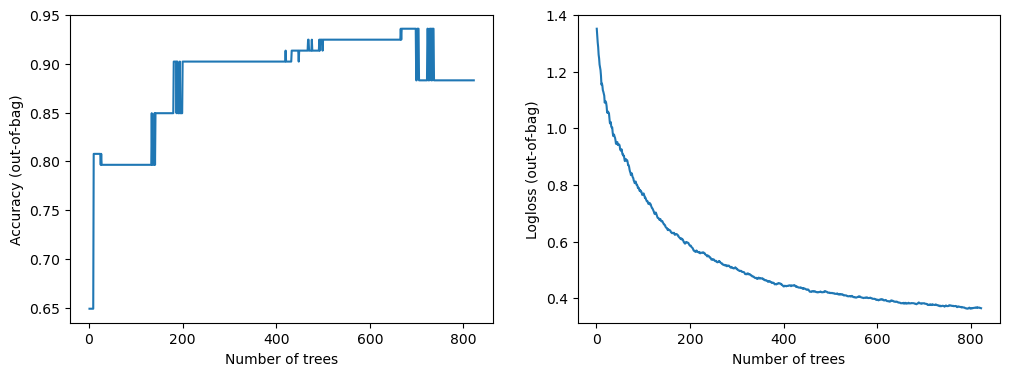


Train: 0.1104 Validation: 0.2472
##### Fold 2
Use /tmp/tmpmoeqqqfk as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:04.5295 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:04.5296 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:04.5296 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.287886. Found 555 examples.
Training model...
Model trained in 0:00:00.749271
Compiling model...


[INFO 23-08-01 13:01:06.5701 UTC kernel.cc:1242] Loading model from path /tmp/tmpmoeqqqfk/model/ with prefix fa6d26edbc614386
[INFO 23-08-01 13:01:06.5771 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3298


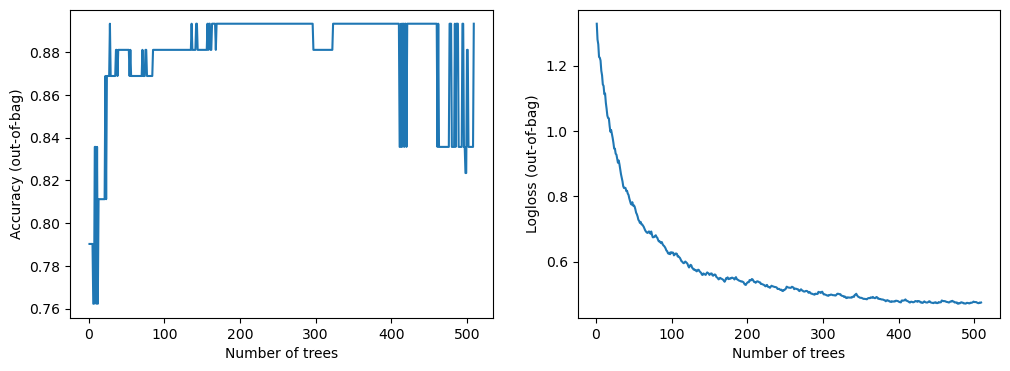


Train: 0.3734 Validation: 0.3298
##### Fold 3
Use /tmp/tmpd2t8sg4s as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:09.2242 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:09.2244 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:09.2244 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.306437. Found 555 examples.
Training model...
Model trained in 0:00:01.436788
Compiling model...


[INFO 23-08-01 13:01:11.9642 UTC kernel.cc:1242] Loading model from path /tmp/tmpd2t8sg4s/model/ with prefix e6af904fc8634ca1
[INFO 23-08-01 13:01:11.9776 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:01:11.9777 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1800


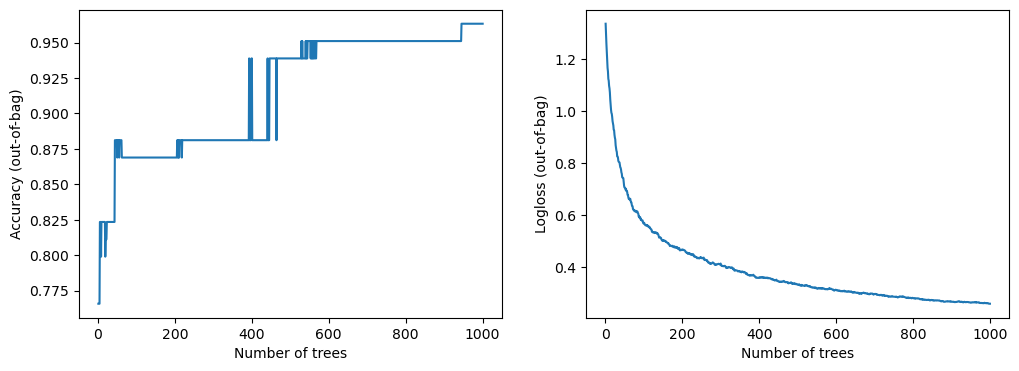


Train: 0.4286 Validation: 0.1800
##### Fold 4
Use /tmp/tmpwhrg8elv as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:14.6135 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:14.6136 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:14.6137 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.278007. Found 555 examples.
Training model...
Model trained in 0:00:00.453869
Compiling model...


[INFO 23-08-01 13:01:16.3504 UTC kernel.cc:1242] Loading model from path /tmp/tmpwhrg8elv/model/ with prefix 6c0b648185884c33
[INFO 23-08-01 13:01:16.3548 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 292ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2218


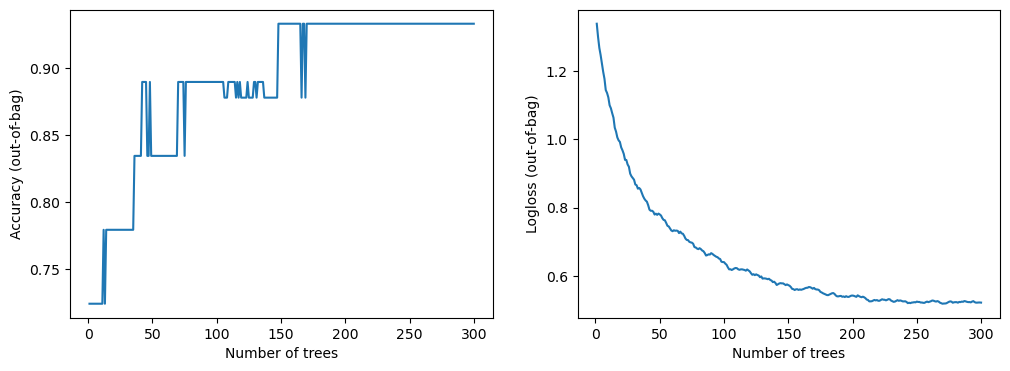


Train: 0.3504 Validation: 0.2218
##### Fold 5
Use /tmp/tmp86wh5ihx as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:18.9952 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:18.9952 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:18.9953 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.296800. Found 555 examples.
Training model...
Model trained in 0:00:00.576252
Compiling model...


[INFO 23-08-01 13:01:20.8732 UTC kernel.cc:1242] Loading model from path /tmp/tmp86wh5ihx/model/ with prefix 0b36d95f0f934e03
[INFO 23-08-01 13:01:20.8787 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2437


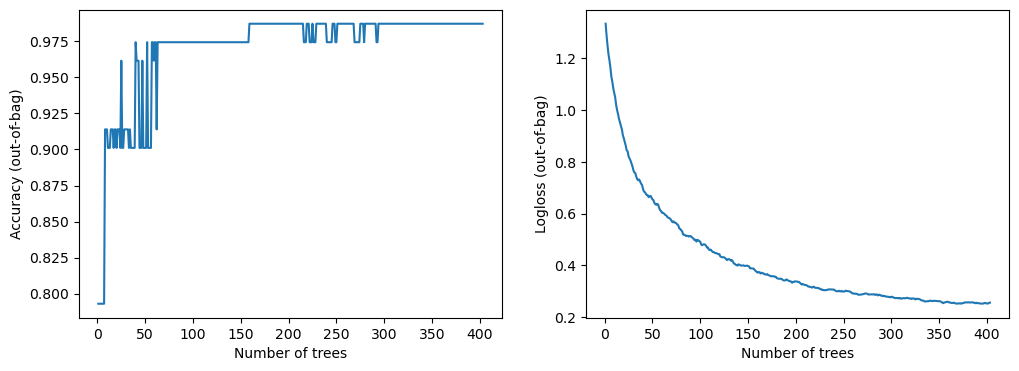


Train: 0.3695 Validation: 0.2437
##### Fold 6
Use /tmp/tmpi9zic05i as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:23.5068 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:23.5068 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:23.5069 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.278552. Found 555 examples.
Training model...
Model trained in 0:00:00.764946
Compiling model...


[INFO 23-08-01 13:01:25.5510 UTC kernel.cc:1242] Loading model from path /tmp/tmpi9zic05i/model/ with prefix ea67307bf70f4b6e
[INFO 23-08-01 13:01:25.5581 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:01:25.5582 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2334


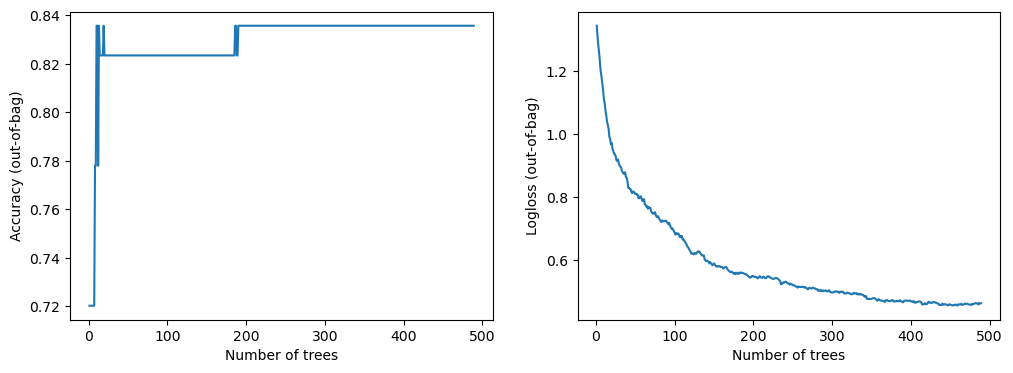


Train: 0.3818 Validation: 0.2334
##### Fold 7
Use /tmp/tmpkkkhsqia as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:28.1038 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:28.1038 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:28.1038 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.254440. Found 555 examples.
Training model...
Model trained in 0:00:00.639266
Compiling model...


[INFO 23-08-01 13:01:30.0023 UTC kernel.cc:1242] Loading model from path /tmp/tmpkkkhsqia/model/ with prefix 3856a0da2ab443ca
[INFO 23-08-01 13:01:30.0083 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1783


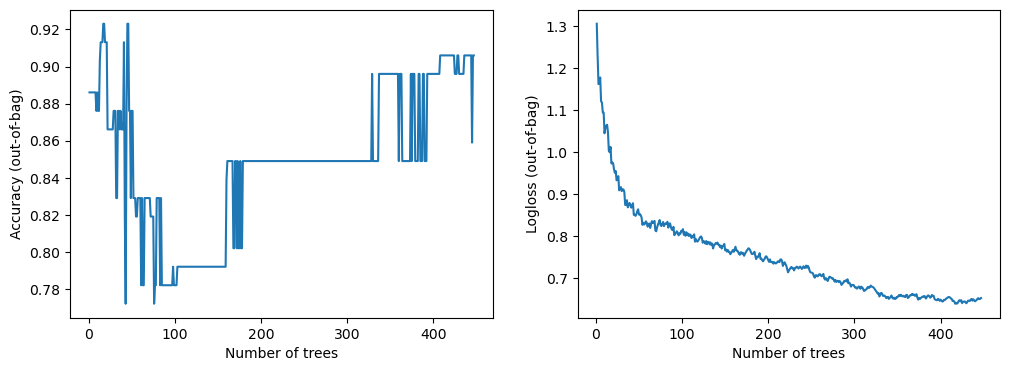


Train: 0.3857 Validation: 0.1783
##### Fold 8
Use /tmp/tmp_jy90m0y as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:32.5795 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:32.5796 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:32.5796 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.253467. Found 556 examples.
Training model...
Model trained in 0:00:00.716752
Compiling model...


[INFO 23-08-01 13:01:34.5516 UTC kernel.cc:1242] Loading model from path /tmp/tmp_jy90m0y/model/ with prefix ed8e4c7bfef64f3a
[INFO 23-08-01 13:01:34.5588 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1534


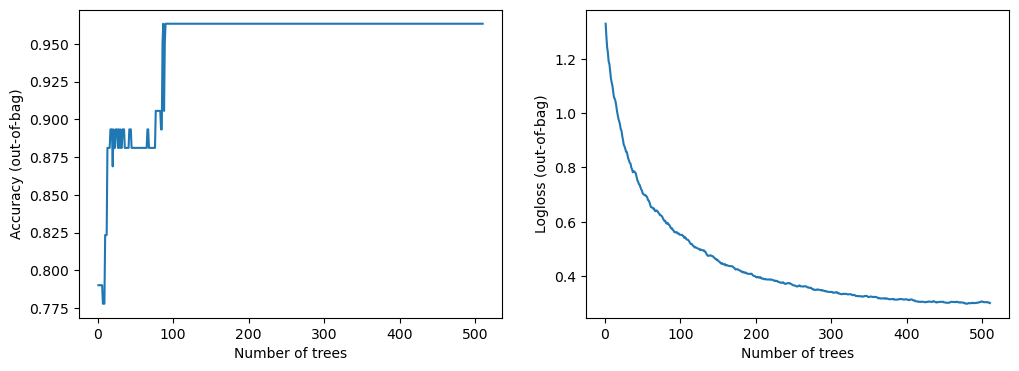


Train: 0.3152 Validation: 0.1534
##### Fold 9
Use /tmp/tmp0evh28zt as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:37.0916 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:37.0918 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:37.0918 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.267481. Found 556 examples.
Training model...
Model trained in 0:00:00.783344
Compiling model...


[INFO 23-08-01 13:01:39.1438 UTC kernel.cc:1242] Loading model from path /tmp/tmp0evh28zt/model/ with prefix f4b785bfaeb44f26
[INFO 23-08-01 13:01:39.1520 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-01 13:01:39.1520 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3722


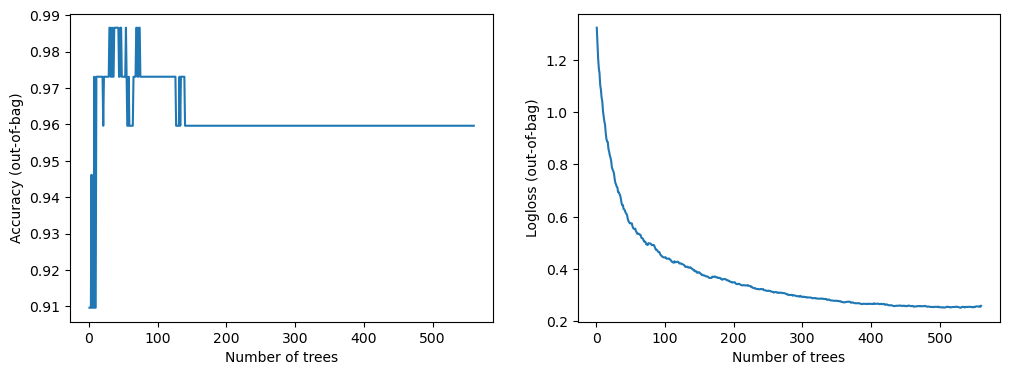


Train: 0.2672 Validation: 0.3722
##### Fold 10
Use /tmp/tmpyk0mtphw as temporary training directory
Reading training dataset...


[WARNING 23-08-01 13:01:41.7316 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:41.7316 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-01 13:01:41.7317 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.275886. Found 556 examples.
Training model...
Model trained in 0:00:00.643154
Compiling model...


[INFO 23-08-01 13:01:43.6534 UTC kernel.cc:1242] Loading model from path /tmp/tmpyk0mtphw/model/ with prefix 496eb98564094626
[INFO 23-08-01 13:01:43.6600 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9836 - balanced_log_loss: 0.1415


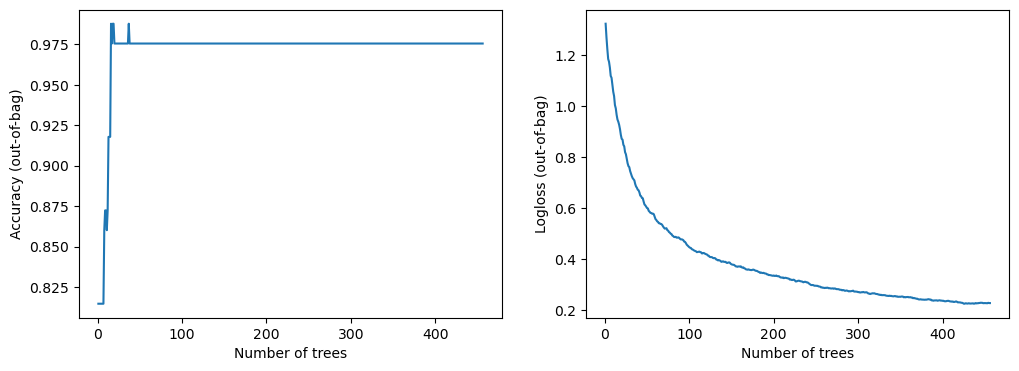


Train: 0.5158 Validation: 0.1415

Train mean: 0.3498 std: 0.1066

Validation mean: 0.2301 std: 0.0742


In [10]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_2 = CV_Ensemble_GBT_2.fit(X=train, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=2, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_2.save(save_path='/kaggle/working/GBT/2')

# Collect attributes and predictions

# train_summary_gbt_2 = CV_Ensemble_GBT_2.X_summary
# valid_summary_gbt_2 = CV_Ensemble_GBT_2.valid_summary
# test_summary_gbt_2 = CV_Ensemble_GBT_2.predict(X=test_out)
# model_gbt_2 = CV_Ensemble_GBT_2.models
# metrics_gbt_2 = CV_Ensemble_GBT_2.metrics

# Cut-Offs

In [11]:
def compute_cut_off(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    # Let's try to find Cutoffs organically
    y_pred.name = 'Pred'
    y_true.name = 'Class'

    tmp = pd.concat([y_pred, y_true], axis=1).sort_index(ascending=True)

    tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
    tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
    tmp['count_cumsum'] = tmp['count'].cumsum()
    tmp['sum_cumsum'] = tmp['sum'].cumsum()

    tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

    tmp['perc_sum'] = [*range(1,101)]

    return tmp

In [12]:
# y_pred = CV_Ensemble_3.predict_proba(train, use_cut_offs=False)
# y_true = train['Class']

# compute_cut_off(y_pred=y_pred, y_true=y_true)

# CV_Ensemble_RF_3.set_cut_offs(lower=0.11,upper=0.892) # 95 perc 0.892 and 52% 0.11

# print(CV_Ensemble_RF_3.cut_off_lower)
# print(CV_Ensemble_RF_3.cut_off_upper)
 
# y_pred_rf_train = CV_Ensemble_3.predict_proba(train, use_cut_offs=True)

# y_pred_rf_train

# print('Before')
# print(balanced_logloss_np(y_pred=y_pred.values,y_true=y_true.values))
# print('After')
# print(balanced_logloss_np(y_pred=y_pred_rf_train,y_true=y_true.values))